# Label Consistent K-SVD
*** Author: Thomas Rolland ***


Implementation of :
https://ieeexplore.ieee.org/document/6516503/

```
A label consistent K-SVD (LC-KSVD) algorithm to learn a discriminative dictionary for sparse coding is presented. In addition to using class labels of training data, we also associate label information with each dictionary item (columns of the dictionary matrix) to enforce discriminability in sparse codes during the dictionary learning process. More specifically, we introduce a new label consistency constraint called "discriminative sparse-code error" and combine it with the reconstruction error and the classification error to form a unified objective function. The optimal solution is efficiently obtained using the K-SVD algorithm. Our algorithm learns a single overcomplete dictionary and an optimal linear classifier jointly. The incremental dictionary learning algorithm is presented for the situation of limited memory resources. It yields dictionaries so that feature points with the same class labels have similar sparse codes. Experimental results demonstrate that our algorithm outperforms many recently proposed sparse-coding techniques for face, action, scene, and object category recognition under the same learning conditions.
```

If you have any question, send me an email at: trolland@protonmail.ch

In [1]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
# Dataset
from tensorflow.examples.tutorials.mnist import input_data
# Dictionart learning algorithms
import spams # http://spams-devel.gforge.inria.fr/

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define usefull function

In [2]:
def create_Q(labels, nb_class, k,n):
    """
     Create the discriminative matrix Q

    Parameters
    ----------
    labels : np.array
        List of all labels, for example [[0,1],[0,1],[1,0]]
    nb_class : int
        Number of classes
    k : int
        Number of atoms in the dictionary
    n : int
        Number of trainning samples

    Returns
    -------
    numpy.array
        Return the matrix Q initialized

    """
    plus_one = (k % nb_class) == 0 
    nb_atoms_per_class = int(math.floor(k/nb_class))
    
    # Init Q 
    Q = np.zeros((k,n))
    for item in range(n):
        locations = labels[item].nonzero() 
        # For all locations
        for place in locations[0]:
            for i in range(nb_atoms_per_class): # Fill
                Q[(nb_atoms_per_class * place)+i,item] = 1 # i.e. atom and sample share the 
                                                            # same label
            if ((place -1 ) == nb_class) and plus_one:
                pass # non-discriminative atoms
    return Q

In [3]:
def LC_KSVD(X, Q, lambda1,m, k):
    """
        LC-KSVD algorithm
        
        Parameters
        ----------
        X  : np.array
            List of all samples vectorized
        Q  : np.array
            Discriminative matrix Q
        lambda1:
            Constant which give influence on the sparse term in the minimization function
        k  : int
            Number of atoms in the dictionary
    """
    param = {'mode':5, 'K':k, 'lambda1':lambda1, 'numThreads':5, 'batchsize':256, 'iter':200}


    # Find a overcomplete dictionary
    
    D_0 = spams.trainDL(X,**param)
    print("D0........................Done")
    # Find sparse linear combination 
    h_0 = spams.omp(X,D_0,lambda1=lambda1) 
    print("H0........................Done")
    
    # Compute A_0 

    lambda2 = 0.5                                   #You can change lambda2 if you want
    I = np.identity(k) 
    tmp = np.dot(h_0.toarray(),Q.T)
    tmp2 = np.linalg.inv(np.dot(h_0 ,np.transpose(h_0)) + lambda2 * I)
    A_0 =  np.dot(tmp2,tmp)
    #A_0 = np.dot(np.dot(Q, np.transpose(h_0)),np.linalg.inv(np.dot(h_0 ,np.transpose(h_0)) + lambda2 * I))
    
    # Save A0
    fileA0 = open('A0_LC-KSVD.mat','wb')

    np.save(fileA0,A_0)
    print(np.shape(A_0))
    print("Initial step..............Done") 

    # Init Ynew and Dnews
    

    Ynew =(np.concatenate([X,math.sqrt(5)*Q])) # here you can change 5 by anything
    Dnew = (np.concatenate([D_0,math.sqrt(5)*A_0])) # here you can change 5 by anything
   
    print("Creation Ynew,Dnew........Done")
    
    # Use K-SVD algorithm 
    Ynew = np.asfortranarray(Ynew,dtype=float)   
    Dnew = np.asfortranarray(Dnew,dtype=float)    
    
    D = spams.trainDL(Ynew,D=Dnew,**param)
   
    print("KSVD......................Done")

    # Extract (D and A) and Normalize them
    D_ext = D[:m] 
    A_ext = D[m:]
    
    Dt = np.transpose(D_ext)
    At = np.transpose(A_ext)
    espilon = 0.00000001 # Just in case to avoid division by 0 but normaly its good
    # You cold remove this espilon if you want
    for i in range(k): # <=> len(At) = len(Dt)
        Dt[i] = Dt[i] / (np.linalg.norm(Dt[i],2) + espilon)
        At[i] = At[i] /(np.linalg.norm(Dt[i],2) + espilon)
    D_hat = np.transpose(Dt)
    A_hat = np.transpose(At)

    # Use OMP algorithm to find h

    D_hat = np.asfortranarray(D_hat,dtype=float)   
    h_hat = spams.omp(X,D_hat,lambda1= lambda1)  

    return D_hat,A_hat,h_hat


## Main

First we get the trainning samples

In [4]:
mnist = input_data.read_data_sets('MNIST_DATA',one_hot=True)
digits = mnist.train.images[:2000]
digits_labels = mnist.train.labels[:2000] # Remove [:number] to train on all dataset

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Preprocessing of our input data

In [5]:
[n,m] = np.shape(digits.data)
X = np.transpose(digits.data)
X = np.asfortranarray(X,dtype=float)

Define some usefull constants

In [6]:
# Number of atoms
k = 1024  # Traditionaly take k = 2 * signal size, here signal size = 784 -> k > 1500
# I choose 1024 only for rapidity of computation

# Sparsity power on the minimization problem
lambda1 = 1.2/math.sqrt(m) # see https://www.di.ens.fr/willow/pdfs/icml09.pdf

# Discriminative matrix Q
Q = create_Q(digits_labels,len(digits_labels[0]),k,n)

Then use the K-SVD algorithm to find D,A and gamma (here Gamma = h)

In [7]:
[D,A,h] = LC_KSVD(X,Q,lambda1,m,k)

D0........................Done
H0........................Done
(1024, 1024)
Initial step..............Done
Creation Ynew,Dnew........Done
KSVD......................Done


Save D and A values

In [8]:
# Save D and A
fileD = open('D_LC-KSVD.mat','wb')
#fileH = open('h_LC-KSVD.mat','wb')
fileA = open('A_LC-KSVD.mat','wb')
np.save(fileD,D)
#np.save(fileH,h.toarray())
np.save(fileA,A)


Note: Be carefull if you want to save h. h is a sparse matrix, you need to use h.todense() to transform this matrix into a numpy array

### Here you can add any classifier and use the result of OMP on the test dataset

In [9]:
digits = mnist.test.images[:10] # Remove [:number] to test on all dataset
[n,m] = np.shape(digits.data)
X = np.transpose(digits.data)
X = np.asfortranarray(X,dtype=float)
lambda1 = 1.2/math.sqrt(m)

Compute sparse coeficients for the test dataset

In [10]:
h_test = spams.omp(X,D,lambda1= lambda1)  
h_test = h_test.todense()
# Note: Here we use @ instead of np.dot for RAM saving
recons = D @ h_test
discriminative_coef = A @ h_test
print(h_test.shape)
print(recons.shape)
print(discriminative_coef.shape)

[[0.         0.         0.         ... 0.         0.50982581 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         2.26418046]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(1024, 10)
(784, 10)
(1024, 10)


show the results

In [11]:
# transpose recons and discriminative for display
h_test = np.transpose(h_test)
recons = np.transpose(recons)
discriminative_coef = np.transpose(discriminative_coef)
data = np.transpose(X)

print(data.shape)
print(h_test.shape)
print(recons.shape)
print(discriminative_coef.shape)

(10, 784)
(10, 1024)
(10, 784)
(10, 1024)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.46205409e-03  9.02010109e-03  1.51832400e-02
   1.37483868e-02  6.16188447e-03  1.00927415e-03  0.00000000e+00
   1.79225399e-02  2.93384453e-02  2.60739453e-02  7.66880776e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 

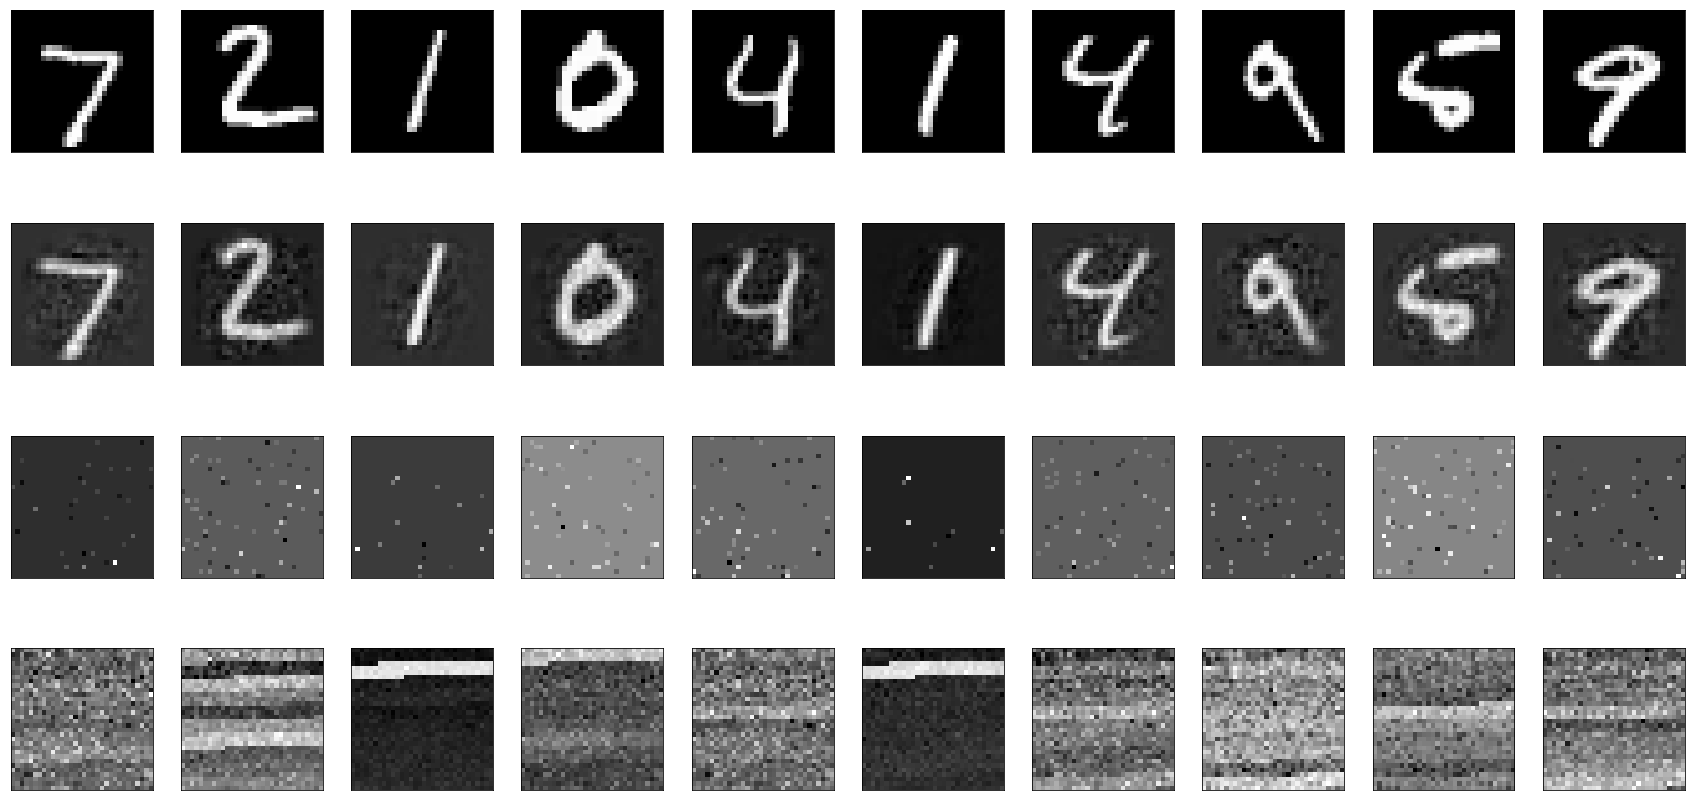

In [14]:
plt.figure(figsize=(30,15))

n_show = 10 #  number of image that we show
for i in range(n_show):
    # display original
    ax = plt.subplot(4,n_show,i+1)
    plt.imshow(data[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4,n_show,i+1+n_show)
    plt.imshow(recons[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display coef
    ax = plt.subplot(4,n_show,i+1+2*n_show)
    plt.imshow(h_test[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    
    # display discriminative coef
    ax = plt.subplot(4,n_show,i+1+3*n_show)
    plt.imshow(discriminative_coef[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()